In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import EdgeWeightNorm, GraphConv
from dgl.data import DGLDataset
import mysql.connector
import dgl.data
import numpy as np
import pandas as pd
import os
from dgl import save_graphs, load_graphs
import matplotlib.pyplot as plt
import random
from Datasets import PaperDataset
from Models import GraphClassificationModelCrossEntropy, GraphClassificationModelBinaryCrossEntropy
import networkx as nx
import scipy.sparse as sp
import itertools


# Connect to database

In [2]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                          host='127.0.0.1',
                          database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}

# Create Validation Set

In [3]:
test_papers = []
with open(r'./test_papers.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        test_papers.append(x)

train_papers = []
with open(r'./train_papers.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        train_papers.append(x)
in_params_train = ','.join(['%s'] * len(train_papers + test_papers))

# Link Prediction on homogenous graph example

In [21]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [22]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [23]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [24]:
from dgl.nn import SAGEConv


# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [25]:
train_pos_g = dgl.graph(
    (train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()
)
train_neg_g = dgl.graph(
    (train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()
)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [26]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

In [27]:
model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
# pred = MLPPredictor(16)
pred = DotPredictor()


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [28]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata["feat"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 0.7072935700416565
In epoch 5, loss: 0.690392792224884
In epoch 10, loss: 0.6704825758934021
In epoch 15, loss: 0.6176695823669434
In epoch 20, loss: 0.5751982927322388
In epoch 25, loss: 0.5501721501350403
In epoch 30, loss: 0.5207079648971558
In epoch 35, loss: 0.5017931461334229
In epoch 40, loss: 0.48637834191322327
In epoch 45, loss: 0.4681086242198944
In epoch 50, loss: 0.45054730772972107
In epoch 55, loss: 0.43027806282043457
In epoch 60, loss: 0.4073181450366974
In epoch 65, loss: 0.3853845000267029
In epoch 70, loss: 0.36678558588027954
In epoch 75, loss: 0.34785374999046326
In epoch 80, loss: 0.3290438652038574
In epoch 85, loss: 0.31080731749534607
In epoch 90, loss: 0.2928200364112854
In epoch 95, loss: 0.2750310003757477
AUC 0.8576114642528245


# Create heterogenous graph

In [4]:
#cursor.execute("select b.ReferenceID, b.ReferencedByID from referencedBy b where b.ReferencedByID in (%s)" % in_params_train, train_papers+test_papers)
#edges = pd.DataFrame(cursor.fetchall(), columns=["ReferenceID", "ReferencedByID"])
def remap(x, mapping):
    return mapping.get(x, x)

cursor.execute("select * from referencedBy b where b.ReferenceID in (select PaperID from Papers) and b.ReferencedByID in (select PaperID from Papers)")
paper_edges = np.array(cursor.fetchall())
all_papers = np.unique(paper_edges)
remapped_papers = {all_papers[i]: i  for i in range(len(all_papers))}
vec_remap = np.vectorize(remap, otypes=[str])
paper_edges = vec_remap(paper_edges, remapped_papers)

cursor.execute("select * from authoredBy where PaperID in (select PaperID from Papers) and (PaperID in (select ReferenceID from referencedBy) or PaperID in (select ReferencedByID from referencedBy))")
author_edges = np.array(cursor.fetchall())
all_authors = np.unique(author_edges)
remapped_authors = {all_authors[i]: i  for i in range(len(all_authors))}

author_edges[:,1] = vec_remap(author_edges[:,1], remapped_authors)
author_edges[:,0] = vec_remap(author_edges[:,0], remapped_papers)

In [5]:
node_types = ["paper", "author"]
edge_types = ["cited", "authored"]

g = dgl.heterograph(
    {
        ('author', 'authored', 'paper'): (author_edges[:,1].astype(int), author_edges[:,0].astype(int)),
        ('paper', 'cites', 'paper'): (paper_edges[:,0].astype(int), paper_edges[:,1].astype(int))
    }
)

In [22]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
u, v = g.edges()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

In [ ]:
top_n = 100
cursor.execute("with temp as (select p.`primary author` as author, p.PaperID from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.publisher = 'Institute of Electrical and Electronics Engineers (IEEE)')"
               "select t.author, count(*) from temp t, authoredBy a, Papers p where a.PaperID not in (select t.PaperID from temp t) and t.author = a.AuthoredByID and a.PaperID = p.PaperID and p.Leaf = false and p.Pub_Year < 2022 group by t.author order by count(*) desc")
t = cursor.fetchall()
val_authors = [author[0] for author in t][:top_n]
in_params = ','.join(['%s'] * len(val_authors))
cursor.execute("create temporary table val as (select p.PaperID from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.publisher = 'Institute of Electrical and Electronics Engineers (IEEE)' and p.`primary author` in (%s))" % in_params, val_authors)

In [4]:
cursor.execute("create temporary table val_ref as (with temp as (select PaperID from val)"
               "select b.ReferenceID as PaperID from temp t, referencedBy b where t.PaperID = b.ReferencedByID)")
cursor.execute("create temporary table val_set as (select PaperID from val union select PaperID from val_ref)")

In [5]:
cursor.execute("select * from val v")
len(cursor.fetchall())

121

In [7]:
# Fetch all the node
cursor.execute("select * from val_set")
val_paper_ids = [paperID[0] for paperID in cursor.fetchall()]

# Fetch all the Authors
cursor.execute("select b.PaperID, b.AuthoredByID from val_set v, authoredBy b where v.PaperID = b.PaperID")
val_authored_by = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])

# Fetch edges
cursor.execute("select b.ReferenceID, b.ReferencedByID from val v, referencedBy b where v.PaperID = b.ReferencedByID")
val_references = pd.DataFrame(cursor.fetchall(), columns=["ReferenceID", "PaperID"])

In [39]:
cursor.execute("select * from val v")
for x in cursor.fetchall():
    print(np.where(val_references["PaperID"].unique() == x[0]))

(array([0]),)
(array([1]),)
(array([2]),)
(array([3]),)
(array([4]),)
(array([5]),)
(array([6]),)
(array([7]),)
(array([8]),)
(array([9]),)
(array([10]),)
(array([11]),)
(array([12]),)
(array([13]),)
(array([14]),)
(array([15]),)
(array([16]),)
(array([17]),)
(array([18]),)
(array([19]),)
(array([20]),)
(array([21]),)
(array([22]),)
(array([23]),)
(array([24]),)
(array([25]),)
(array([26]),)
(array([27]),)
(array([28]),)
(array([29]),)
(array([30]),)
(array([31]),)
(array([32]),)
(array([33]),)
(array([34]),)
(array([35]),)
(array([36]),)
(array([37]),)
(array([38]),)
(array([39]),)
(array([40]),)
(array([41]),)
(array([42]),)
(array([43]),)
(array([44]),)
(array([45]),)
(array([46]),)
(array([47]),)
(array([48]),)
(array([49]),)
(array([50]),)
(array([51]),)
(array([52]),)
(array([53]),)
(array([54]),)
(array([55]),)
(array([56]),)
(array([57]),)


# Train set

In [3]:
#cursor.execute("create temporary table x as (select distinct `primary author` from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.publisher='Institute of Electrical and Electronics Engineers (IEEE)')")
cursor.execute("create temporary table train_set as (select p.PaperID, p.authorCount from Papers p, authoredBy b where p.Pub_Year < 2022 and p.Leaf = False and b.PaperID = p.PaperID and b.AuthoredByID in (%s) group by p.PaperID)" % in_params, val_authors)

NameError: name 'in_params' is not defined

In [5]:
cursor.execute("select * from train_set t")
len(cursor.fetchall())

ProgrammingError: 1146 (42S02): Table 'computervision.train_set' doesn't exist

In [16]:
# fetch train nodes
cursor.execute("select distinct b.ReferenceID from train_set t, referencedBy b where t.PaperID = b.ReferencedByID and t.authorCount <= 3")
train_reference_paperID = [paperID[0] for paperID in cursor.fetchall()]
cursor.execute("select distinct PaperID from train_set")
train_no_reference_paperID = [paperID[0] for paperID in cursor.fetchall()]
train_paper_ids = list(set(list(filter(lambda x: x not in train_no_reference_paperID,train_reference_paperID)) + train_no_reference_paperID))
train_index = len(train_no_reference_paperID)

# fetch train authors
in_params = ','.join(['%s'] * len(train_paper_ids))
cursor.execute("select b.PaperID, b.AuthoredByID from authoredBy b where b.PaperID in (%s)" % in_params,  train_paper_ids)
train_authored_by = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])
#train_authored_by = train_authored_by[train_authored_by["PaperID"].isin(train_paper_ids)]

# fetch edges
cursor.execute("select b.ReferenceID, b.ReferencedByID from Papers p, referencedBy b where p.PaperID in (select PaperID from train_set) and p.PaperID = b.ReferencedByID")
train_references = pd.DataFrame(cursor.fetchall(), columns=["ReferenceID", "PaperID"])
train_references = train_references[train_references["ReferenceID"].isin(train_authored_by["PaperID"])]

In [17]:
# transform the authorIDS
enumeration = {x: idx for idx, x in enumerate(pd.concat([train_authored_by["AuthorID"], val_authored_by["AuthorID"]]).unique())}
val_authored_by["AuthorID"] = val_authored_by["AuthorID"].apply(lambda x: enumeration[x])
train_authored_by["AuthorID"] = train_authored_by["AuthorID"].apply(lambda x: enumeration[x])
total_authors_len = len(enumeration)

In [25]:
training_dataset = PaperDataset(train_authored_by, train_references, label_size=total_authors_len, one_hot_encoded=True)
paper_training_graph = training_dataset[0]
validation_dataset = PaperDataset(val_authored_by, val_references, label_size=total_authors_len, val=True, one_hot_encoded=True)
paper_validation_graph = validation_dataset[0]

0
1000
2000
3000
4000
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
0
1000
2000
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [17]:
total_authors_len

12802

In [14]:
save_graphs("./graphs/2022_temp_split.bin", [paper_training_graph, paper_validation_graph])

In [16]:
model = GraphClassificationModelBinaryCrossEntropy(12802, 8, paper_training_graph.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(200,paper_training_graph,optimizer)

ValueError: Target size (torch.Size([886, 12802])) must be the same as input size (torch.Size([886, 8]))

## Create Paper Graph

In [11]:
top_n = 500
cursor.execute("with temp as (select distinct p.`primary author` as author from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.publisher = 'Institute of Electrical and Electronics Engineers (IEEE)')"
               "select t.author, count(*) from temp t, Papers p where p.Leaf = False and p.Pub_Year < 2022 and t.author = p.`primary author` group by t.author order by count(*) desc")
t = cursor.fetchall()
val_authors = [author[0] for author in t][:top_n]
in_params = ','.join(['%s'] * len(val_authors))
cursor.execute("create temporary table val as (select p.PaperID from Papers p where p.Leaf = False and p.Pub_Year = 2022 and p.publisher = 'Institute of Electrical and Electronics Engineers (IEEE)' and p.`primary author` in (%s))" % in_params, val_authors)

ProgrammingError: 1050 (42S01): Table 'val' already exists

In [12]:
cursor.execute("create temporary table val_ref as (with temp as (select PaperID from val)"
               "select b.ReferenceID as PaperID from temp t, referencedBy b where t.PaperID = b.ReferencedByID)")
cursor.execute("create temporary table val_set as (select PaperID from val union select PaperID from val_ref)")

In [13]:
cursor.execute("select * from val_set")
val_paper_ids = [paperID[0] for paperID in cursor.fetchall()]

# Fetch all the Authors
cursor.execute("select p.PaperID, p.`primary author` from val_set v, Papers p where v.PaperID = p.PaperID")
val_authored_by = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])

# Fetch edges
cursor.execute("select b.ReferenceID, b.ReferencedByID from val v, referencedBy b where v.PaperID = b.ReferencedByID")
val_references = pd.DataFrame(cursor.fetchall(), columns=["ReferenceID", "PaperID"])

# Train

In [10]:
cursor.execute("create temporary table train_set as (select p.PaperID from Papers p where p.Pub_Year < 2022 and p.Leaf = False and p.`primary author` in (%s) group by p.PaperID)" % in_params, val_authors)

In [17]:
cursor.execute("select * from train_set t")
a = cursor.fetchall()
x = pd.DataFrame(a, columns=["PaperID"])
x

,PaperID
0,002c640135661bd624d00a733b223b4b6a5240cd
1,0042e732d026befda9ccd7eda4e671ea40ed5af9
2,005f48e06e3af1509824cd2f3162d1a2255e3083
3,00b7b84d7644ac4bb4f37edc747066f3c1a477e5
4,01126b2a931b7c0e65a2ffcffe8a185dc36692d4
...,...
1744,ff7a055f21f46d6da05f297fb798201b9e03f4f1
1745,ffc4065a3edb5dc18d86390c765378a7085cf5f1
1746,ffc4cc6cd7a547db398807cd439ba13ac7646fef
1747,ffdc37284a87a4c0d09d6804253acc94ae9685a1


In [20]:
x = pd.DataFrame(a, columns=["PaperID"])
x.to_csv("./train_set.csv")

In [12]:
cursor.fetchall()

[]

In [17]:
# fetch train nodes
cursor.execute("select distinct b.ReferenceID from train_set t, referencedBy b, Papers p where t.PaperID = b.ReferencedByID and p.PaperID = b.ReferenceID and p.`primary author` is not null")
train_reference_paperID = [paperID[0] for paperID in cursor.fetchall()]
cursor.execute("select distinct PaperID from train_set")
train_no_reference_paperID = [paperID[0] for paperID in cursor.fetchall()]
train_paper_ids = list(set(list(filter(lambda x: x not in train_no_reference_paperID,train_reference_paperID)) + train_no_reference_paperID))
train_index = len(train_no_reference_paperID)

# fetch train authors
in_params = ','.join(['%s'] * len(train_paper_ids))
cursor.execute("select p.PaperID, p.`primary author` from Papers p where p.PaperID in (%s) and p.`primary author` is not null" % in_params,  train_paper_ids)
train_authored_by = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])
#train_authored_by = train_authored_by[train_authored_by["PaperID"].isin(train_paper_ids)]

# fetch edges
cursor.execute("select b.ReferenceID, b.ReferencedByID from Papers p, referencedBy b, Papers p2 where p.PaperID in (select PaperID from train_set) and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` is not null")
train_references = pd.DataFrame(cursor.fetchall(), columns=["ReferenceID", "PaperID"])
train_references = train_references[train_references["ReferenceID"].isin(train_authored_by["PaperID"])]

In [18]:
# transform the authorIDS
enumeration = {x: idx for idx, x in enumerate(pd.concat([train_authored_by["AuthorID"], val_authored_by["AuthorID"]]).unique())}
val_authored_by["AuthorID"] = val_authored_by["AuthorID"].apply(lambda x: enumeration[x])
train_authored_by["AuthorID"] = train_authored_by["AuthorID"].apply(lambda x: enumeration[x])
total_authors_len = len(enumeration)

In [19]:
enumeration

{'145690248': 0,
 '144040982': 1,
 '1881617': 2,
 '48559520': 3,
 '49411511': 4,
 '11543835': 5,
 '2144602244': 6,
 '2069707975': 7,
 '144574904': 8,
 '35649732': 9,
 '2276155': 10,
 '1765674': 11,
 '1706883847': 12,
 '46242344': 13,
 '38880529': 14,
 '22275884': 15,
 '2393320': 16,
 '1781565': 17,
 '1854465': 18,
 '2118579343': 19,
 '50490186': 20,
 '150238792': 21,
 '143853801': 22,
 '35570245': 23,
 '3414570': 24,
 '5107862': 25,
 '1664758918': 26,
 '2109685046': 27,
 '143749410': 28,
 '2575799': 29,
 '1730200': 30,
 '49416917': 31,
 '1726733': 32,
 '2154930338': 33,
 '2486760': 34,
 '2065543878': 35,
 '145784436': 36,
 '80360658': 37,
 '1747779': 38,
 '33200800': 39,
 '1689269': 40,
 '31481425': 41,
 '2577847': 42,
 '1822702': 43,
 '3040583': 44,
 '2662178': 45,
 '79494968': 46,
 '47811393': 47,
 '8511875': 48,
 '26095346': 49,
 '143754377': 50,
 '2255687': 51,
 '151485208': 52,
 '144802290': 53,
 '35030998': 54,
 '1383996606': 55,
 '31394603': 56,
 '66319300': 57,
 '2518628': 58,


In [ ]:
training_dataset = PaperDataset(train_authored_by, train_references, label_size=total_authors_len, one_hot_encoded=True)
paper_training_graph = training_dataset[0]
validation_dataset = PaperDataset(val_authored_by, val_references, label_size=total_authors_len, val=True, one_hot_encoded=True)
paper_validation_graph = validation_dataset[0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


/home/david/PycharmProjects/bachelor_thesis/Graph Neural Network/Datasets.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  node_labels = torch.tensor(feature_vector, dtype=torch.int32)


tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [13]:
x = paper_training_graph.to_networkx()

In [20]:
for wc in nx.weakly_connected_components(x):
    print(wc)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [13]:
model = GraphClassificationModelBinaryCrossEntropy(7209, 8, paper_training_graph.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(2,paper_training_graph,optimizer)

Epoch 0: loss=0.6932, train_acc=0.9976, val_acc=0.0000
Epoch 1: loss=0.4975, train_acc=1.0000, val_acc=0.0000


In [14]:
val_mask = paper_validation_graph.ndata["train_mask"]
pred_val = model.predict(paper_validation_graph, paper_validation_graph.ndata["train_mask"])
label_val = torch.max(paper_validation_graph.ndata["label"][val_mask],dim=1)[1]
(pred_val == label_val).float().mean().item()

0.7894737124443054

In [28]:
pred_val

tensor([1718,  378,  829,  426,   54,   84, 1052,  536, 1585,  868,  526,   65,
         832,  120,  558,  613, 2902,  164,  892,  536,  474, 1750,  378,  832,
         102,  248, 1221,  141,  737,  847,  950,  295, 1535,  141,  651, 1542,
        1286,  378,  262, 1750,  118, 1926,  667,  892, 3063,  181,  474,  847,
        1323,  178,  426,  613,  470,  141,  402,   65,    7])

In [70]:
label_val

tensor([1718,  378,  218,  426,   54,   84, 1052,  536, 1585,  868,  526,   65,
         832,  516,  558,  613, 2902,  164,  892, 1718, 1750,  829,  526,  267,
         102,  248, 1221,  101,  737,  847,  950,  447, 1535,  141,  651, 1542,
        1286,  295,  262, 1750,  118, 1926,  667, 1286, 3063,  181,  474,  847,
        1323,  178,  426,  120,  470,  141,  402,   65,    7])

In [29]:
(pred_val == label_val)

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
        False, False, False, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True])

In [76]:
cursor.execute("select b.ReferenceID, b.ReferencedByID from Papers p, referencedBy b where p.`primary author` = '1730200' and p.Leaf = 0 and b.ReferencedByID = p.PaperID")
edges_ex = cursor.fetchall()
#1189083916dab5882eacc42908353c94c32df5b4
#3450321

In [77]:
ref = [x[1] for x in edges_ex]

In [78]:
G=nx.from_edgelist(edges_ex)

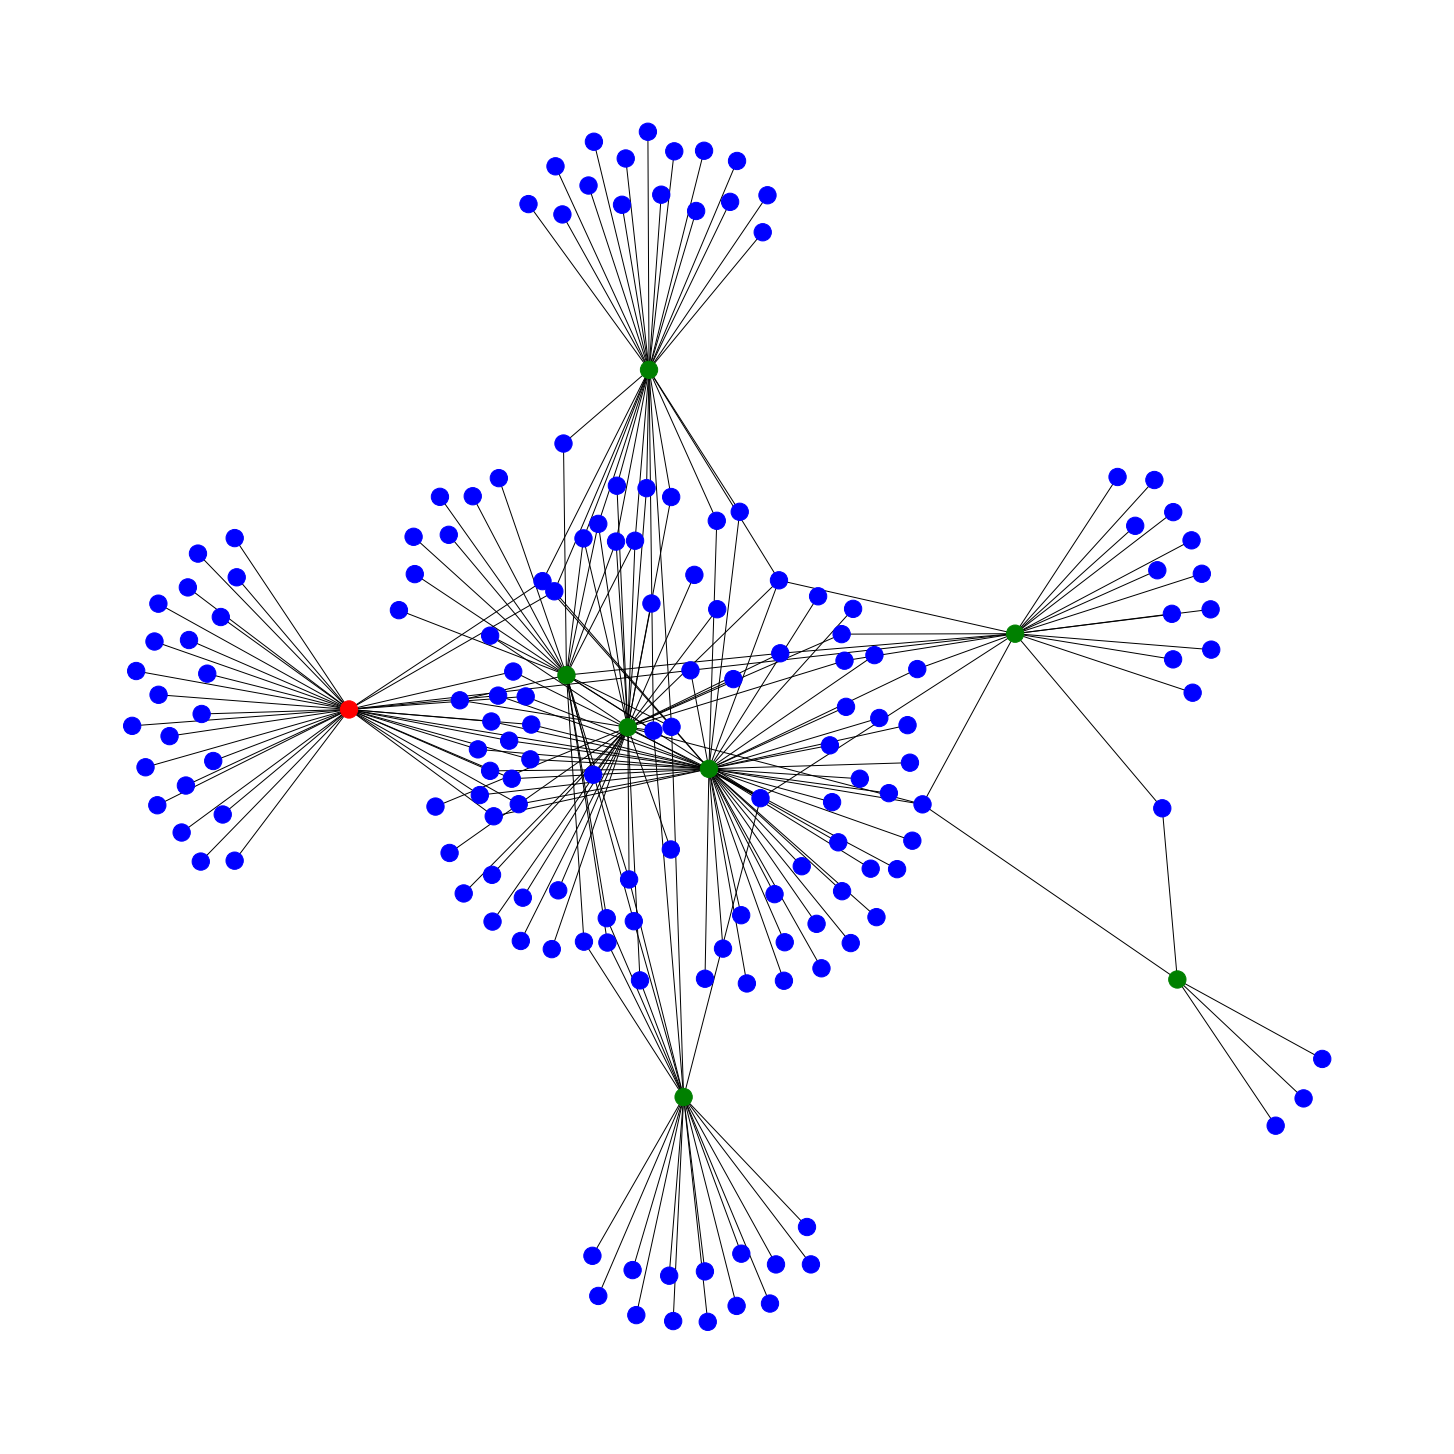

In [79]:
plt.figure(3,figsize=(20,20))
color_map = []
for node in G:
    if node == "fecf49bf2d7346c1a437c51a49c2f5dd1df8139c":
        color_map.append('red')
    elif node in ref:
        color_map.append('green')
    else:
        color_map.append('blue')
nx.draw(G, node_color=color_map)
plt.show()

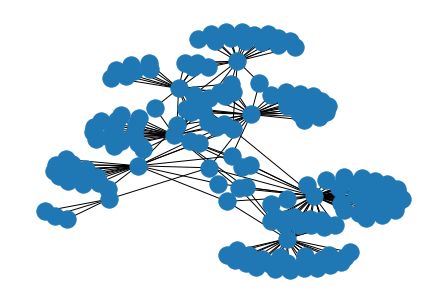

In [57]:
nx.draw(G)

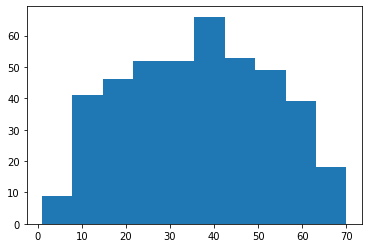

In [23]:
plt.hist(paper_training_graph.in_degrees(), range=(1,70))
plt.show()

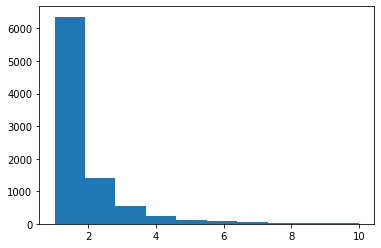

In [27]:
plt.hist(paper_training_graph.out_degrees(), range=(1,10))
plt.show()

# Old paper graph

In [58]:
# need to define max year due to memory limitations
max_year = 2012
author_count = 1

In [59]:
cursor.execute("select r.ReferenceID as rID, p.PaperID as pID from Papers p, referencedBy r where p.Leaf = False and p.authorCount <= %s and p.Pub_Year <= %s and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%'", [author_count, max_year])

# Create complete Graph
# Fetch references (edges)
references_raw = cursor.fetchall()
references_df = pd.DataFrame(references_raw, columns=["ReferenceID","PaperID"])

# Fetch all papers (nodes)
cursor.execute("CREATE TEMPORARY TABLE temp_table AS (select p.PaperID as PaperID from Papers p where p.Leaf = False and p.Pub_Year <= %s and p.authorCount <= %s  UNION select r.ReferenceID as PaperID from Papers p, referencedBy r where p.Leaf = False and p.Pub_Year <= %s and p.authorCount <= %s and r.ReferencedByID = p.PaperID and r.ReferenceID not like '11111%')", [max_year, author_count, max_year, author_count])
cursor.execute("select * from temp_table")
all_papers_series = cursor.fetchall()

all_papers_remap_ids = {all_papers_series[x][0]: x for x in range(0, len(all_papers_series))}

# Remap the references to id
#references_df = references_df.applymap(lambda x: all_papers_remap_ids[x])

# Fetch authors and remap to label
cursor.execute("select b.PaperID, b.AuthoredByID from authoredBy b, temp_table t where b.PaperID = t.PaperID")
authored_by_df = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "AuthorID"])
#authored_by_df["PaperID"] = authored_by_df["PaperID"].apply(lambda x: all_papers_remap_ids[x])

all_author_ids = authored_by_df["AuthorID"].unique()
mapped_author_ids = {all_author_ids[index]: index for index in range(0, len(all_author_ids))}
authored_by_df["AuthorID"] = authored_by_df["AuthorID"].apply(lambda x: mapped_author_ids[x])
total_authors_len = len(authored_by_df["AuthorID"].unique())

# Create Validation Set
cursor.execute("select p.PaperID as PaperID from Papers p where p.Leaf = False and p.Pub_Year <= %s and p.authorCount <= %s order by p.Pub_year", [max_year, author_count])
val_papers_raw = cursor.fetchall()
#.applymap(lambda x: all_papers_remap_ids[x])
reference_paper = pd.DataFrame(val_papers_raw, columns=["PaperID"])
reference_paper_w_authors = pd.merge(reference_paper, authored_by_df, on="PaperID")
val_split = int(len(reference_paper_w_authors)*0.2)
reference_paper_w_authors["PaperID"] = reference_paper_w_authors["PaperID"].astype(str)
max_val_size = int(len(reference_paper_w_authors)*0.2)
reference_paper_w_grouped_authors = reference_paper_w_authors.groupby("AuthorID", as_index=False).agg({'PaperID': ','.join})
val_papers_index = []
for grouped_authors in reference_paper_w_grouped_authors.iterrows():
    papers = grouped_authors[1]["PaperID"].split(",")
    if len(papers) > 1:
        val_split = round(len(papers) * 0.33)
        val_papers_index += papers[-val_split:]
        if len(val_papers_index) >= max_val_size:
            break
training_set_index = len(val_papers_raw)

# Split validation from training
print(len(authored_by_df["AuthorID"].unique()))
# Extract the edges existing in the complete reference list
validation_nodes_references = references_df[references_df["PaperID"].isin(val_papers_index)]
validation_nodes_references_list = validation_nodes_references["ReferenceID"].to_list()
references_df.drop(references_df[references_df["PaperID"].isin(val_papers_index)].index, inplace=True)
validation_nodes_list = val_papers_index + validation_nodes_references_list


# Validation nodes
validation_nodes = authored_by_df[authored_by_df["PaperID"].isin(validation_nodes_list)]

# Drop all papers existing in the validation set except the ones that are used as a reference
validation_no_references = authored_by_df[-authored_by_df["PaperID"].isin(references_df["ReferenceID"].to_list())]
validation_removal = validation_no_references[validation_no_references["PaperID"].isin(val_papers_index)]
authored_by_df.drop(authored_by_df[authored_by_df["PaperID"].isin(validation_removal)].index, inplace=True)

6749


In [62]:
references_df

,ReferenceID,PaperID
0,12619eab27d96eced98988151231ccea82acbb8e,0144bd0be143c725977e51b6e9d24ad627cb6b48
1,1789c11bf54b45dbb2427c2109012f1aa9b3f472,0144bd0be143c725977e51b6e9d24ad627cb6b48
2,1a790963f438d41f127c81745ffd42599bc388d3,0144bd0be143c725977e51b6e9d24ad627cb6b48
3,5dc1597737c9912838d699299e1ff94c489bbc3d,0144bd0be143c725977e51b6e9d24ad627cb6b48
4,6e483ec7530df88a1960b377a609d9d709ba7dd6,0144bd0be143c725977e51b6e9d24ad627cb6b48
...,...,...
4819,99bcee4232fce1dfa81b1480ff569d46b1aedfc5,ff5e888c01eb11f03b0b2db8916635619783992c
4820,9a3efb2e3b06aae8a595b5758d436d4a603fb4e6,ff5e888c01eb11f03b0b2db8916635619783992c
4821,ae8259682989c7b9f7a88c69c4b908e7d671fc25,ff5e888c01eb11f03b0b2db8916635619783992c
4822,caa0fd34e50bb417fae3ee32f667e78fe5b198bc,ff5e888c01eb11f03b0b2db8916635619783992c


In [6]:
# Init graph
training_dataset = PaperDataset(authored_by_df, references_df, label_size=total_authors_len, one_hot_encoded=True)
paper_training_graph = training_dataset[0]
validation_dataset = PaperDataset(validation_nodes, validation_nodes_references, label_size=total_authors_len, val=True, one_hot_encoded=True)
paper_validation_graph = validation_dataset[0]
#paper_graph = paper_graph.add_self_loop()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
tensor([[1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
0
1000
2000
3000
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


In [7]:
# Save the graph
save_graphs("./graphs/2022_temp_split.bin", [paper_training_graph, paper_validation_graph])

## Load Graph

In [7]:
glist, label_dict = load_graphs("./graphs/single_author_2009_train_test.bin")
paper_graph = glist[0]

In [9]:
glist

[Graph(num_nodes=2018, num_edges=1741,
       ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(3172,), dtype=torch.int32), 'feat': Scheme(shape=(3172,), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=405, num_edges=425,
       ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(3172,), dtype=torch.int32), 'feat': Scheme(shape=(3172,), dtype=torch.int32)}
       edata_schemes={})]

## Graph Neural Network for Paper prediction

In [77]:
paper_training_graph.ndata["val_mask"]

KeyError: 'val_mask'

In [75]:
# Initialize the model and the loss function
model = GraphClassificationModelBinaryCrossEntropy(3172, 256, paper_training_graph.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(200,paper_training_graph,optimizer)

KeyError: 'val_mask'

In [7]:
torch.save(model.state_dict(), "./models/single_author_2014")

# Initialize Graph

In [87]:
logits = torch.tensor([[-3., -3., 3.]])
F.binary_cross_entropy_with_logits(logits, torch.tensor([[0,0,1]]).float(), pos_weight=torch.tensor([12000.]))

tensor(194.3817)

In [1]:
if not os.path.isfile("./data2.bin"):
    added_labels = []
    cursor.execute("select a.AuthorID from Authors a")
    all_authors = cursor.fetchall()
    all_authors_index = [(x, all_authors[x][0]) for x in range(0, len(all_authors))]
    authors = pd.DataFrame(all_authors_index, columns=["key", "AuthorID"])
    max_id = authors["key"].max()
    complete_references_raw = pd.DataFrame({'key_x' : [],  "key_y" : [], "year": [], "PaperID": []})
    conc_list = []
    # Fetch data per year (otherwise it would crash)
    for year in range(2000,2010):
        print(year)
        cursor.execute(f"select a.AuthoredByID, a2.AuthoredByID, p.Pub_Year, p.PaperID from Papers p, authoredBy a, authoredBy a2, referencedBy b where p.PaperID = b.ReferencedByID and a.AuthoredByID != 0 and p.PaperID = a.PaperID and a2.AuthoredByID != 0 and p.Pub_Year = {year} and b.ReferenceID = a2.PaperID")
        entries = cursor.fetchall()
        entries_df = pd.DataFrame(entries, columns=["A", "B", "year", "PaperID"])
        temp = pd.merge(entries_df, authors, left_on="B", right_on="AuthorID")
        all_references = pd.merge(authors, temp, left_on="AuthorID", right_on="A")
        subset_all_references = all_references[["key_x", "key_y", "year", "PaperID"]]
        complete_references_raw = pd.concat([complete_references_raw, subset_all_references])

    # Choose latest papers with existing authors in the training as validation
    aggregated_references = complete_references_raw.groupby(["PaperID", "key_x", "year"], as_index=False).count()
    author_count = aggregated_references.groupby(["key_x"]).size().reset_index(name='count')
    author_count = author_count[author_count["count"] != 1]
    aggregated_references = pd.merge(aggregated_references, author_count, on="key_x")
    validation_subset_sample = random.sample(range(len(author_count)), int(val_split*len(author_count)))
    for val_id in validation_subset_sample:
        # Get latest paper of that author
        latest_paper_information = aggregated_references[aggregated_references["key_x"] == author_count.iloc[val_id]["key_x"]].sort_values("year").iloc[-1]
        val_author_id = latest_paper_information["key_x"]
        val_paper_id = latest_paper_information["PaperID"]
        val_author_label_id = authors[authors["key"] == val_author_id]["AuthorID"].values[0]
        added_labels.append(val_author_id)
        # Remap the id
        max_id += 1
        authors = pd.concat([authors, pd.DataFrame({"key": [max_id], "AuthorID": [val_author_label_id]})])
        aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] == val_author_id), ["key_x"]] \
            = max_id
        aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)


    complete_references_raw = complete_references_raw.groupby(["key_x", "key_y"]).size().reset_index(name='C')
    complete_references_raw = complete_references_raw.rename(columns={"key_x":"Author", "key_y":"RefAuthor", "C":"Count"})
    dataset = AuthorDataset(authors, complete_references_raw)
    graph = dataset[0]
    save_graphs("./data.bin", [graph])
else: # Load graph if exists
    glist, label_dict = load_graphs("./data.bin")
    graph = glist[0]

NameError: name 'os' is not defined

In [100]:
print()

        key_x
190  450237.0


In [107]:
aggregated_references.drop(aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index, inplace=True)

In [113]:
aggregated_references.loc[(aggregated_references["PaperID"] == val_paper_id) & (aggregated_references["key_x"] != max_id)].index

Int64Index([], dtype='int64')

## Properties

In [61]:
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")
in_degrees = graph.in_degrees().numpy()
out_degrees = graph.out_degrees().numpy()

Number of nodes: 733726
Number of edges: 25392667


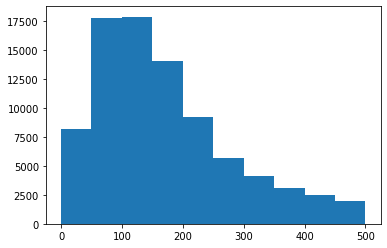

In [43]:
plt.hist(in_degrees[in_degrees != 0], range=(0,500))
plt.show()

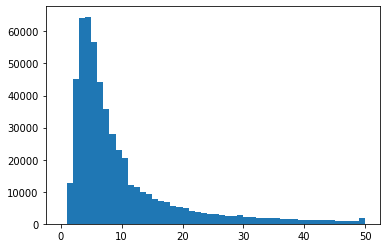

In [57]:
plt.hist(out_degrees[out_degrees != 0], range=(0,50), bins=50)
plt.show()

In [67]:
node_subset = random.sample(range(graph.num_nodes()), 4000)
sub_graph = graph.subgraph(node_subset)

# Graph Neural Network

In [73]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()

        self.conv1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)
        self.conv2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True, norm='none', weight=True, bias=True)

    def forward(self, graph, inputs, edge_weight):
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        #print(norm_edge_weight)
        h = self.conv1(graph, inputs, edge_weight=norm_edge_weight)
        h = F.relu(h)
        h = self.conv2(graph, h, edge_weight=norm_edge_weight)
        return h

In [47]:
node_features = graph.ndata['feat'].float()
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
edge_weights = graph.edata['weight'].float()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [48]:
def evaluate(model, graph, features, edge_weights, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features, edge_weights)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        print(indices)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [50]:
len(edge_weights)

29100277

In [51]:
model = GCN(in_feats=n_features, hid_feats=12, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10000):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features, edge_weights)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask].long())
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, edge_weights, node_labels, valid_mask)
    print(acc)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

    # Save model if necessary.  Omitted in this example.

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 2153415372304 bytes. Error code 12 (Cannot allocate memory)

# Sample GNN

In [3]:
sample_g = dgl.graph(([1, 2, 2, 1, 1, 3, 3, 2, 3, 2, 5, 1, 2, 2, 1, 3, 2, 5],[0, 0, 1, 3, 4, 4, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11]))
sample_g.ndata['feat'] = torch.randn(12, 1)
sample_g.ndata['label'] = torch.tensor(list(range(8)) + [0, 7,1, 4, 7])
#sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,1,3,1,1,1,1,1,1,1,1]).type(torch.float32)
sample_g.edata['weights'] = torch.tensor([2,2,1,1,1,3,1,1,3,3,1,3,3,3,3,3,3,3]).type(torch.float32)
t_mask = torch.zeros(12, dtype=torch.bool)
v_mask = torch.zeros(12, dtype=torch.bool)
t_mask[:8] = True
v_mask[8:] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask
#sample_g = dgl.add_self_loop(sample_g)

DGLError: Expect number of features to match number of nodes (len(u)). Got 13 and 12 instead.

In [97]:
a = torch.ones(4,5)
torch.sum(a, dim=0)

tensor([4., 4., 4., 4., 4.])

In [70]:
merged_tensor = [torch.zeros(5,5), torch.zeros(5,5)]
torch.stack(merged_tensor, dim=0).shape

torch.Size([2, 5, 5])

In [46]:
torch.randn(5,1)

tensor([[ 1.5373],
        [-0.9285],
        [-0.6500],
        [ 1.0641],
        [ 0.8817]])

In [3]:
sample_g = dgl.DGLGraph()
sample_g.add_nodes(11)
sample_g.add_edges([0,1,2,3,5,6,6,8,9,10,2,3],[1,3,3,4,4,4,7,7,7,7,7,7])
label_tensor = torch.tensor([[1,0,0],[1,0,0],[1,0,0],[1,0,0],[0,1,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1],[0,0,1],[0,0,1]])
feature_tensor = []

rand_feat = torch.randn(11,1)
#sample_g.ndata['feat'] = torch.tensor([[1,0,0],[1,0,0],[1,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,0,0],[0,0,1],[0,0,1],[0,0,1]])
sample_g.ndata['feat'] = torch.cat([rand_feat, label_tensor], dim=1)
sample_g.ndata['label'] = label_tensor
t_mask = torch.zeros(11, dtype=torch.bool)
v_mask = torch.zeros(11, dtype=torch.bool)#
t_mask[3] = True
t_mask[4] = True

v_mask[7] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask
#g = sample_g.add_self_loop()
g = sample_g
#sample_g = sample_g.add_self_loop()

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [5]:
model = GraphClassificationModelBinaryCrossEntropy(4, 8, sample_g.ndata["label"].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(30,sample_g,optimizer)

tensor([[ 0.3481,  1.0000,  0.0000,  0.0000],
        [ 0.1966,  1.0000,  0.0000,  0.0000],
        [-1.4645,  1.0000,  0.0000,  0.0000],
        [ 1.2140,  1.0000,  0.0000,  0.0000],
        [ 0.2513,  0.0000,  1.0000,  0.0000],
        [ 0.6077,  0.0000,  1.0000,  0.0000],
        [ 1.5089,  0.0000,  1.0000,  0.0000],
        [-0.9404,  0.0000,  0.0000,  1.0000],
        [-1.2057,  0.0000,  0.0000,  1.0000],
        [ 0.4911,  0.0000,  0.0000,  1.0000],
        [ 0.9173,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5947, -0.7002,  0.4896,  0.5605, -0.3657,  0.3903, -0.2060,  0.5745],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3395, -0.5289,  0.5050,  0.6351,  0.1810,  0.4512,  0.2643,  0.7429],
        [-1.1183, -0.6940,  0.5052,  0.3009, -1.0916,  0.5811, -0.2997,  0.7958],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
 

In [9]:
model = GraphClassificationModelBinaryCrossEntropy(4, 8, sample_g.ndata["label"].shape[1])

In [10]:
model.conv1.weight

Parameter containing:
tensor([[ 0.6044,  0.0533,  0.6634,  0.2557, -0.6091, -0.0597, -0.0645, -0.1829],
        [-0.0872,  0.6863, -0.5126, -0.5823,  0.0528, -0.0797,  0.3372, -0.4292],
        [-0.2725, -0.4941,  0.3504, -0.1718,  0.5077, -0.3448,  0.3425, -0.5622],
        [ 0.1720, -0.2399, -0.2481,  0.5660, -0.6758,  0.0305, -0.0531, -0.5593]],
       requires_grad=True)

In [6]:
sample_g = dgl.DGLGraph()
sample_g.add_nodes(4)
sample_g.add_edges([0,2,0,2],[1,1,3,3])
label_tensor = torch.tensor([0,1,2,1])

sample_g.ndata['feat'] = torch.tensor([[0],[3],[1],[1]])
sample_g.ndata['label'] = label_tensor
t_mask = torch.zeros(4, dtype=torch.bool)
v_mask = torch.zeros(4, dtype=torch.bool)#
t_mask[1] = True
v_mask[3] = True
sample_g.ndata['train_mask'] = t_mask
sample_g.ndata['val_mask'] = v_mask
sample_g.ndata['test_mask'] = v_mask

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [5]:
model = GraphClassificationModelCrossEntropy(1, 8, sample_g.ndata["label"].shape[0])
print(model.conv1.weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.fit(20,sample_g,optimizer)

Parameter containing:
tensor([[-0.7933,  0.2199, -0.4469,  0.1610]], requires_grad=True)
1
1
Epoch 0: loss=1.3251, train_acc=1.0000, val_acc=1.0000
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 10: loss=0.4831, train_acc=1.0000, val_acc=1.0000
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [11]:
weights = torch.randn((1,5))
weights

tensor([[ 0.8822, -0.4069,  1.2420,  0.3634, -0.1228]])

In [15]:
f = sample_g.ndata['feat']
f

tensor([[0],
        [3],
        [1],
        [1]])

In [13]:
conv1 = GraphConv(1, 3, allow_zero_in_degree=True, weight=False, bias=False)

In [14]:
h = conv1(sample_g, sample_g.ndata["feat"], weight=weights)
h

tensor([[ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.4411, -0.2035,  0.6210,  0.1817, -0.0614],
        [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.4411, -0.2035,  0.6210,  0.1817, -0.0614]])

In [36]:
f*weights

tensor([[-0.0000, -0.0000,  0.0000],
        [-1.6973, -0.1067,  6.2549],
        [-0.5658, -0.0356,  2.0850],
        [-0.5658, -0.0356,  2.0850]])

In [31]:
f

tensor([[0],
        [3],
        [1],
        [1]])

In [39]:
f[0]*weights

tensor([[-0., -0., 0.]])

In [38]:
f[2]*weights

tensor([[-0.5658, -0.0356,  2.0850]])

In [40]:
f[1]*weights + f[2]*weights

tensor([[-2.2630, -0.1423,  8.3398]])